## Text Classification with BERT

usando texto sem pontuações sem stop_words
, foram removidos os textos outliers.





In [1]:
## Instalando as dependências necessárias
# ! pip install -q ipywidgets

# #Vizualizacao e manipulacao de dados
# ! pip install -q pandas
# ! pip install matplotlib
# ! pip install seaborn

# ! pip3 install  torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
# ! pip install  transformers
# ! pip install  scikit-learn

# Tratamento de dados
# ! pip install -U  pip setuptools wheel
# ! pip install -U  spacy
# ! python -m spacy download en_core_web_sm

### Importando dependencias


In [2]:
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW
from transformers import (
    BertTokenizer, 
    BertModel,
    get_linear_schedule_with_warmup,
)
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

Definir nome do modelo, e diretorio para salvar o modelo posteriormente


In [3]:
# Obter o diretório de trabalho atual
MODEL_NAME= "MultiClassification"
PATH_ATUAL = os.getcwd()
PATH_MODEL_SAVED = os.path.join(PATH_ATUAL, f"{MODEL_NAME}.pth")

print("O diretório de trabalho atual é:", PATH_MODEL_SAVED)


O diretório de trabalho atual é: d:\tcc2\guilherme\4_Multiclass_Classification_Models\BERT\model2\class_pos_neg\text_nots_outliers_punct_not_stop_words\MultiClassification.pth


### Baixar CSV DAtaset

Usar o dataset obtido por meio do scraper

In [4]:
DATA_PATH = "D:/tcc2/guilherme/3_Data_Processing/data/Scraper_Dataset_treated_text_sem_outliers.csv"
df = pd.read_csv(DATA_PATH)
df = df[['review','rating','qtd_tokens']]
df


,review,rating,qtd_tokens
0,movie takes place fantasy land Absolutely ridi...,1,34
1,sentimental pathetic slow conventionally voice...,1,17
2,things life understand universe begin happens ...,1,143
3,movie inspired brilliant Stir Crazy starring G...,1,84
4,life understand gushing cornball sentimental P...,1,41
...,...,...,...
40099,bloody good time Vol 1 watching Uma Thurman sl...,10,118
40100,Uma Thurman returns Bride time looks continue ...,10,157
40101,Vol 2 completely different tone features film ...,10,16
40102,movie great mixes different genres movies mart...,10,60


In [5]:
df.duplicated(subset=['review', 'rating'],).sum()


0

In [6]:
df = df.drop_duplicates(subset=['review','rating'],ignore_index=True)
print(df.duplicated().sum())
df


0


,review,rating,qtd_tokens
0,movie takes place fantasy land Absolutely ridi...,1,34
1,sentimental pathetic slow conventionally voice...,1,17
2,things life understand universe begin happens ...,1,143
3,movie inspired brilliant Stir Crazy starring G...,1,84
4,life understand gushing cornball sentimental P...,1,41
...,...,...,...
40099,bloody good time Vol 1 watching Uma Thurman sl...,10,118
40100,Uma Thurman returns Bride time looks continue ...,10,157
40101,Vol 2 completely different tone features film ...,10,16
40102,movie great mixes different genres movies mart...,10,60


In [7]:
# def get_qtd_tokens(x):
#     return len(x.split())

# df.loc[:, 'qtd_tokens'] = df['review'].apply(get_qtd_tokens)
# df


### Gráfico de distribuição de palavras


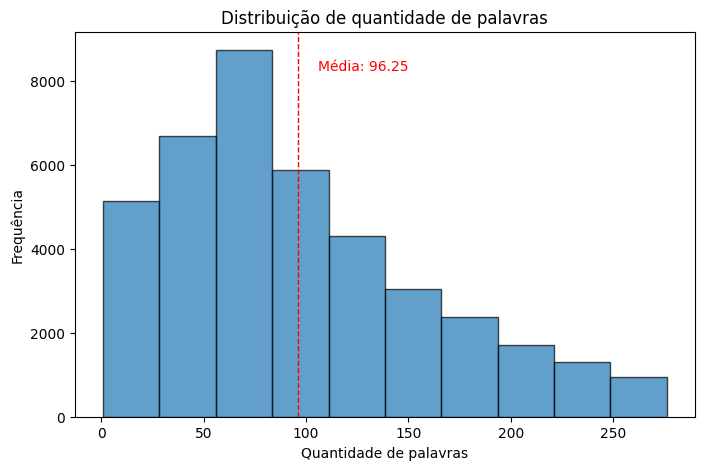

In [8]:
# Plotar o gráfico por quantidade de palavras
def plot_distr_qtd_palavras(series,title):
    mean_length = series.mean()

    plt.figure(figsize=(8, 5))
    plt.hist(series, edgecolor="k", alpha=0.7)
    plt.axvline(mean_length, color="r", linestyle="dashed", linewidth=1)
    plt.text(
        x=mean_length * 1.1,
        y=plt.ylim()[1] * 0.9,
        s=f"Média: {mean_length:.2f}",
        color="r",
    )
    plt.title(title)
    plt.xlabel("Quantidade de palavras")
    plt.ylabel("Frequência")
    plt.show()

title= "Distribuição de quantidade de palavras"
plot_distr_qtd_palavras(df["qtd_tokens"], title)

In [9]:
print("Analise estatistica de quantidade de tokens")
df['qtd_tokens'].describe()

Analise estatistica de quantidade de tokens


count    40104.000000
mean        96.252419
std         63.220850
min          1.000000
25%         49.000000
50%         81.000000
75%        134.000000
max        276.000000
Name: qtd_tokens, dtype: float64

In [10]:
print("value counts df['rating']:")
print(df["rating"].value_counts())


value counts df['rating']:
rating
8     5398
9     5290
7     5273
10    5167
6     4330
5     3526
1     3349
4     2800
3     2619
2     2352
Name: count, dtype: int64


In [11]:
# Iterar sobre cada categoria
def balance_dataframe_groups(df,column, NUM_ROWS_PER_CATEGORY):
    # Lista para armazenar os DataFrames de cada categoria(um por categoria)
    df_list_rating = []
    for rating, group in df.groupby(column):
        rating_str = str(rating)  # Convertendo para string
        num_samples = min(NUM_ROWS_PER_CATEGORY[rating_str], len(group))
        # Selecionar aleatoriamente o número correto de linhas para cada categoria
        sampled_rows = group.sample(n=num_samples, random_state=42)
        # Adicionar os dados selecionados à lista
        df_list_rating.append(sampled_rows)
    balanced_df =pd.concat(df_list_rating)
    return balanced_df 

In [12]:
# Defina o número de linhas desejado para cada categoria
NUM_ROWS_PER_CATEGORY = {
    "10": 4000,
    "9": 4010,
    "8": 6000,
    "7": 6000,
    "6": 5000,
    "5": 5000,
    "4": 5000,
    "3": 2702,
    "2": 2400,
    "1": 3400,
}
# Obter dataframe balenceado
balanced_df = balance_dataframe_groups(df, "rating", NUM_ROWS_PER_CATEGORY)

# Verificar se as categorias estão balanceadas
print(balanced_df["rating"].value_counts())

rating
8     5398
7     5273
6     4330
9     4010
10    4000
5     3526
1     3349
4     2800
3     2619
2     2352
Name: count, dtype: int64


In [13]:
balanced_df

,review,rating,qtd_tokens
20683,find incongruous people color singing dancing ...,1,61
29853,pacing terrible 20 year old daughter wanted wa...,1,16
17058,love Tarantino able director follow unique sty...,1,67
13739,going leap leep things simple cumulative effec...,1,184
34821,opens badly deceptive watch carefully patient ...,1,260
...,...,...,...
32080,Probably best crime investigation film watched...,10,18
38874,Amores perros debut Alejandro Iñárritu big mov...,10,42
39598,cases Aladdin Disney cartoon Robin Williams Ge...,10,60
29658,Missed cinema found DVD Incredible emotional f...,10,28


Guardando os dados fora do balanceamento para analise posterior, se necessário


In [14]:
# # Crie uma série com todos os índices únicos
# # df original 
# df_indices = pd.Series(df.index)
# # Crie uma série com os índices que estão no balanced_df
# balanced_indices = pd.Series(balanced_df.index)
# # Selecione os índices que não estão no balanced_df
# indices_teste = df_indices[~df_indices.isin(balanced_indices)]
# # Crie um novo dataframe com os índices não presentes no balanced_df
# df_fora_balanceamento = df.loc[indices_teste]


In [15]:
# df_fora_balanceamento

In [16]:
# # Para Classe Positivo[7,8,9,10] e Negativo [...]
def categorize_rating(rating):
    if int(rating) <= 6:
        return 0
    else:
        return 1

In [17]:
balanced_df["rating"] = balanced_df["rating"].apply(categorize_rating)
print(balanced_df["rating"].value_counts())


rating
0    18976
1    18681
Name: count, dtype: int64


Executar a celular abaixo somente se for necessário balancear novamente

In [18]:
# Defina o número de linhas desejado para cada categoria
NUM_ROWS_PER_CATEGORY = {
    "1": 18500,
    "0": 18500,
}
# Obter dataframe balenceado
balanced_df = balance_dataframe_groups(balanced_df, "rating", NUM_ROWS_PER_CATEGORY)

# Verificar se as categorias estão balanceadas
print(balanced_df["rating"].value_counts())

rating
0    18500
1    18500
Name: count, dtype: int64


In [19]:
balanced_df

,review,rating,qtd_tokens
10752,kid remember watching Indiana Jones getting bo...,0,77
29675,OK totally missed point idiot reviews talk hea...,0,40
16488,liked Dancer Dark Lilya 4 Dogville similar mov...,0,129
30649,entire movie promising start present focus rep...,0,45
35830,watched noticed Best picture winner cover thou...,0,59
...,...,...,...
7994,WhiplashBeing drummer means range beer bottles...,1,126
24608,summer 1999 biggest surprise hits Star Wars Am...,1,62
27858,Esposito investigator criminal court Buenos Ai...,1,123
33962,gon na lie like little bit anticlimatic,1,11


Tonar o df balanceado como padrão


In [20]:
df = balanced_df

In [21]:
df

,review,rating,qtd_tokens
10752,kid remember watching Indiana Jones getting bo...,0,77
29675,OK totally missed point idiot reviews talk hea...,0,40
16488,liked Dancer Dark Lilya 4 Dogville similar mov...,0,129
30649,entire movie promising start present focus rep...,0,45
35830,watched noticed Best picture winner cover thou...,0,59
...,...,...,...
7994,WhiplashBeing drummer means range beer bottles...,1,126
24608,summer 1999 biggest surprise hits Star Wars Am...,1,62
27858,Esposito investigator criminal court Buenos Ai...,1,123
33962,gon na lie like little bit anticlimatic,1,11


In [22]:
df.describe()

,rating,qtd_tokens
count,37000.000000,37000.000000
mean,0.500000,95.371324
std,0.500007,62.850772
min,0.000000,1.000000
25%,0.000000,49.000000
50%,0.500000,80.000000
75%,1.000000,132.000000
max,1.000000,276.000000


In [23]:
def load_texts_labels(df):
    texts = df["review"].tolist()
    labels = df["rating"].tolist()
    return texts, labels

In [24]:
texts, labels = load_texts_labels(df)


In [25]:
class TextClassificationDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            return_tensors="pt",
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
        )
        return {
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            "label": torch.tensor(label),
        }

In [26]:
class MultiClassClassifier(nn.Module):
    def __init__(self, bert_model_name: str, hidden_size: int, num_outputs: int):
        super(MultiClassClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.dropout = nn.Dropout(0.1)
        self.linear1 = nn.Linear(self.bert.config.hidden_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, num_outputs)

    def forward(self, input_ids, attention_mask):
        outputs_bert = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs_bert.pooler_output
        dropout = self.dropout(pooled_output)
        logits = F.relu(self.linear1(dropout))
        logits = self.linear2(logits)

        return logits

In [27]:
def train_model_epoch(
    model: MultiClassClassifier, data_loader, optimizer, scheduler, loss_func, device
):
    model.train()
    
    losses = []
    model_prediction = []
    actual_labels = []
    
    for batch in tqdm(data_loader, colour="green", desc="Train_epoch: "):

        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

       
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        losses.append(loss.item())
        _, preds = torch.max(outputs, dim=1)
        model_prediction.extend(preds.cpu().tolist())
        actual_labels.extend(labels.cpu().tolist())

        

    train_accuracy = accuracy_score(actual_labels, model_prediction)
    train_loss = np.mean(losses)

    return train_accuracy, train_loss


In [28]:
def eval_model_epoch(
    model: MultiClassClassifier,
    data_loader: TextClassificationDataset,
    loss_func,
    device: str,
):
    model.eval()

    losses = []
    model_prediction = []
    real_labels = []

    with torch.no_grad():
        for batch in tqdm(data_loader, colour="blue", desc="Validation_epoch: "):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            
            _, preds = torch.max(outputs, dim=1)
            
            model_prediction.extend(preds.cpu().tolist())
            real_labels.extend(labels.cpu().tolist())
            loss = loss_func(outputs, labels)
            losses.append(loss.item())
            
    val_losses = np.mean(losses)
    val_accuracies = accuracy_score(real_labels, model_prediction)
    report = classification_report(real_labels, model_prediction, output_dict=False)
    
    return (val_accuracies, val_losses, report)

In [29]:
# Set up parameters
BERT_MODEL_NAME = "bert-base-uncased"
hidden_size = 10 #Tamanho oculto, neuronios
num_outputs = 2 # numero de classes de saida [negativo,positivo]
max_length = 256 # 128
batch_size = 8  # 16, 32
num_epochs = 4 #recomended in the Bert Article [2,3,4]
learning_rate = 3e-5 # Taxa de aprendizagem (Adam): 5e-5, 3e-5, 2e-5 

In [30]:
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

In [31]:
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    texts, labels, test_size=0.3, random_state=42
)


val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, random_state=42
)



In [32]:
train_dataset = TextClassificationDataset(
    train_texts, train_labels, tokenizer, max_length
)
val_dataset = TextClassificationDataset(val_texts, val_labels, tokenizer, max_length)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

# # Create prediction_dataset
test_dataset = TextClassificationDataset(test_texts, test_labels, tokenizer, max_length)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultiClassClassifier(BERT_MODEL_NAME,hidden_size=hidden_size,num_outputs= num_outputs).to(device)

In [34]:
optimizer = AdamW(model.parameters(), lr=learning_rate)
total_steps = len(train_dataloader) * num_epochs
#: Isso configura o agendador de taxa de aprendizado.
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0, num_training_steps=total_steps
)

loss_func = nn.CrossEntropyLoss().to(device)

In [35]:
%%time

import time
import winsound

# Definindo a frequência e a duração do bip
frequency = 400  # Define a frequência para 2500 Hertz
duration = 500  # Define a duração para 1000 ms == 1 segundo



history_epoch = {
    "train_losses": [],
    "train_accuracies": [],
    "val_losses": [],
    "val_accuracies": [],
    "val_reports": [],
}

best_accuracy = 0
epochs_without_improvements = 0

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    print("-" * 50)

    # Treinamento
    train_accuracy, train_loss = train_model_epoch(
        model, train_dataloader, optimizer, scheduler, loss_func, device
    )
    # Validation
    val_accuracy, val_loss, report = eval_model_epoch(
        model, val_dataloader, loss_func, device
    )

    history_epoch["train_losses"].append(train_loss)
    history_epoch["train_accuracies"].append(train_accuracy)
    history_epoch["val_losses"].append(val_loss)
    history_epoch["val_accuracies"].append(val_accuracy)
    history_epoch["val_reports"].append(report)

    print(f"Train => Loss = {train_loss:.4f}, Accuracy = {train_accuracy:.4f}")
    print(f"Validation => Loss = {val_loss:.4f}, Accuracy = {val_accuracy:.4f}")
    print(report)
    print()
    if val_accuracy > best_accuracy:
        try:
            torch.save(model.state_dict(), PATH_MODEL_SAVED)
            print("Modelo salvo com sucesso!")
        except Exception as e:
            print("Ocorreu um erro ao tentar salvar o modelo.")
            print("Detalhes do erro:", str(e))
        epochs_without_improvements = 0
        best_accuracy = val_accuracy
    else:
        epochs_without_improvements += 1

    if epochs_without_improvements > 4:
        break
     # Seu código aqui
    time.sleep(1)  # Simulando um tempo de processamento
    winsound.Beep(frequency, duration) 


Epoch 1/4
--------------------------------------------------


Train_epoch:   0%|          | 0/3238 [00:00<?, ?it/s]d:\tcc2\guilherme\.venv\Lib\site-packages\transformers\models\bert\modeling_bert.py:435: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
Validation_epoch: 100%|██████████| 694/694 [01:26<00:00,  8.04it/s]


Train => Loss = 0.4830, Accuracy = 0.7658
Validation => Loss = 0.3880, Accuracy = 0.8324
              precision    recall  f1-score   support

           0       0.87      0.79      0.83      2799
           1       0.80      0.88      0.84      2751

    accuracy                           0.83      5550
   macro avg       0.83      0.83      0.83      5550
weighted avg       0.84      0.83      0.83      5550


Modelo salvo com sucesso!
Epoch 2/4
--------------------------------------------------


Validation_epoch: 100%|██████████| 694/694 [01:22<00:00,  8.42it/s]


Train => Loss = 0.3340, Accuracy = 0.8625
Validation => Loss = 0.3842, Accuracy = 0.8429
              precision    recall  f1-score   support

           0       0.85      0.84      0.84      2799
           1       0.84      0.85      0.84      2751

    accuracy                           0.84      5550
   macro avg       0.84      0.84      0.84      5550
weighted avg       0.84      0.84      0.84      5550


Modelo salvo com sucesso!
Epoch 3/4
--------------------------------------------------


Validation_epoch: 100%|██████████| 694/694 [01:27<00:00,  7.92it/s]


Train => Loss = 0.2516, Accuracy = 0.9050
Validation => Loss = 0.4078, Accuracy = 0.8485
              precision    recall  f1-score   support

           0       0.85      0.84      0.85      2799
           1       0.84      0.85      0.85      2751

    accuracy                           0.85      5550
   macro avg       0.85      0.85      0.85      5550
weighted avg       0.85      0.85      0.85      5550


Modelo salvo com sucesso!
Epoch 4/4
--------------------------------------------------


Validation_epoch: 100%|██████████| 694/694 [01:26<00:00,  8.00it/s]


Train => Loss = 0.1781, Accuracy = 0.9383
Validation => Loss = 0.4207, Accuracy = 0.8456
              precision    recall  f1-score   support

           0       0.84      0.85      0.85      2799
           1       0.85      0.84      0.84      2751

    accuracy                           0.85      5550
   macro avg       0.85      0.85      0.85      5550
weighted avg       0.85      0.85      0.85      5550


CPU times: total: 19min 49s
Wall time: 1h 30min 27s


In [36]:
history_epoch

{'train_losses': [0.48303130286538065,
  0.333988874540345,
  0.2515591625337057,
  0.17805784068819897],
 'train_accuracies': [0.7658301158301158,
  0.8625482625482626,
  0.904980694980695,
  0.9383397683397683],
 'val_losses': [0.3879881822839594,
  0.38415935479362173,
  0.4078405145877806,
  0.42068991795187594],
 'val_accuracies': [0.8324324324324325,
  0.8428828828828829,
  0.8484684684684685,
  0.8455855855855856],
 'val_reports': ['              precision    recall  f1-score   support\n\n           0       0.87      0.79      0.83      2799\n           1       0.80      0.88      0.84      2751\n\n    accuracy                           0.83      5550\n   macro avg       0.83      0.83      0.83      5550\nweighted avg       0.84      0.83      0.83      5550\n',
  '              precision    recall  f1-score   support\n\n           0       0.85      0.84      0.84      2799\n           1       0.84      0.85      0.84      2751\n\n    accuracy                           0.84    

In [37]:
print("train_accuracies: ", history_epoch['train_accuracies'])
print("val_accuracies: ",history_epoch['val_accuracies'])
print(history_epoch['val_reports'][3])

train_accuracies:  [0.7658301158301158, 0.8625482625482626, 0.904980694980695, 0.9383397683397683]
val_accuracies:  [0.8324324324324325, 0.8428828828828829, 0.8484684684684685, 0.8455855855855856]
              precision    recall  f1-score   support

           0       0.84      0.85      0.85      2799
           1       0.85      0.84      0.84      2751

    accuracy                           0.85      5550
   macro avg       0.85      0.85      0.85      5550
weighted avg       0.85      0.85      0.85      5550



### Plot Graph losses and acurracies


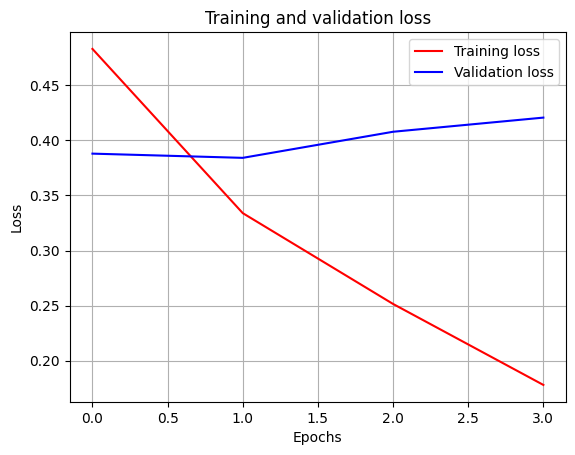

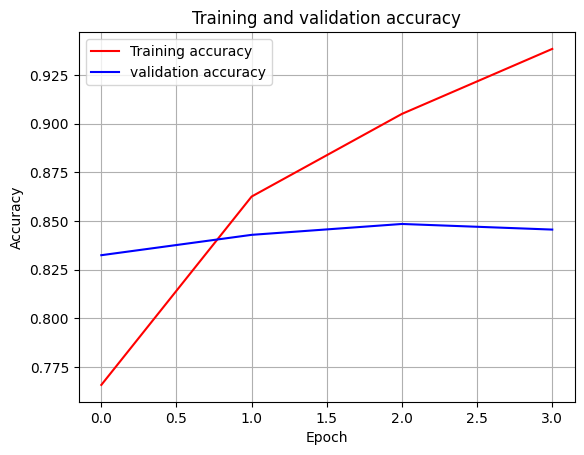

In [38]:
import matplotlib.pyplot as plt


train_loss = history_epoch["train_losses"]
val_loss = history_epoch["val_losses"]
# Plotting the training and validation loss
def plot_loss_fun_graph(train_loss, val_loss):
    plt.plot(train_loss, "r", label="Training loss")
    plt.plot(val_loss, "b", label="Validation loss")
    plt.title("Training and validation loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()
    plt.show()
    
plot_loss_fun_graph(train_loss, val_loss)


# Plotting the training and validation accuracy
train_acc = history_epoch["train_accuracies"]
val_acc = history_epoch["val_accuracies"]
# Encontrar o índice do melhor valor de acurácia de validação
def plot_accurary_graph(train_acc, val_acc):
    best_epoch = np.argmax(val_acc)
    plt.clf()
    plt.plot(train_acc, "r", label="Training accuracy")
    plt.plot(val_acc, "b", label="validation accuracy")
    plt.title("Training and validation accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid()
    plt.legend()
    plt.show()


plot_accurary_graph(train_acc, val_acc)

## Saving & Loading Model for Inference



Save:


In [39]:
# PATH_MODEL_SAVE = "sentiment_classifier_Bert_IMDB_Dataset_eith_lemma.pth"
# torch.save(model.state_dict(), PATH_MODEL_SAVE)

load:


In [40]:
# # PATH_MODEL_SAVE = "sentiment_classifier_en_49500_reviews.pth"
# saved_model = MultiClassClassifier(BERT_MODEL_NAME,hidden_size, num_outputs).to(device)
# saved_model.load_state_dict(torch.load(PATH_MODEL_SAVE))
# # saved_model.eval()

## Sentiment prediction

### Evaluation in test_data


### Get predicitons in test_texts and test_labels

In [41]:
def get_predictions(model, data_loader, device):
    model = model.eval()

    # corresponde ao indice(classe) com maior probabilidade na saída do modelo
    predictions = []
    # corresponde ao indice real(classe verdadeira)
    real_values = []

    with torch.no_grad():
        for batch in tqdm(data_loader):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)
            m_output = model(input_ids=input_ids, attention_mask=attention_mask)
            probs = F.softmax(m_output, dim=1)

            _, max_index = torch.max(probs, dim=1)

            predictions.extend(max_index)
            real_values.extend(labels)

    predictions = torch.stack(predictions).cpu()
    real_values = torch.stack(real_values).cpu()

    return predictions, real_values

In [42]:
#  CArregando com o modelo final atualizado
test_predictions, test_real_values=get_predictions(model,test_dataloader,device)

100%|██████████| 694/694 [01:14<00:00,  9.32it/s]


In [43]:
classes_names = ["negativo", "positivo"]
test_accuracies = accuracy_score(test_predictions, test_real_values)

test_report = classification_report(
    test_predictions, test_real_values, target_names=classes_names, output_dict=False
)
print(f"A precisão foi: {test_accuracies*100:.4f}")
print(test_report)

A precisão foi: 85.2072
              precision    recall  f1-score   support

    negativo       0.86      0.84      0.85      2793
    positivo       0.84      0.86      0.85      2757

    accuracy                           0.85      5550
   macro avg       0.85      0.85      0.85      5550
weighted avg       0.85      0.85      0.85      5550



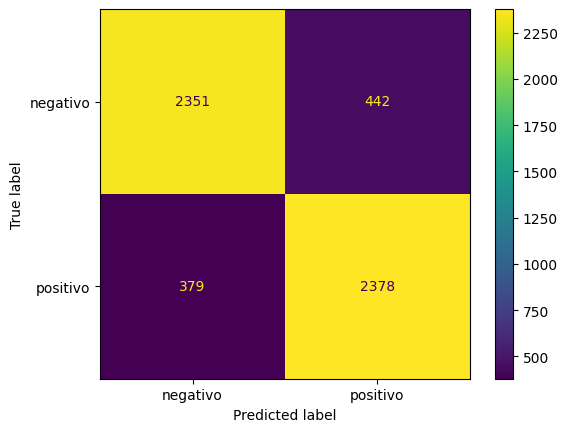

In [44]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(test_predictions,test_real_values)
cm_display = ConfusionMatrixDisplay(cm,display_labels=classes_names).plot()

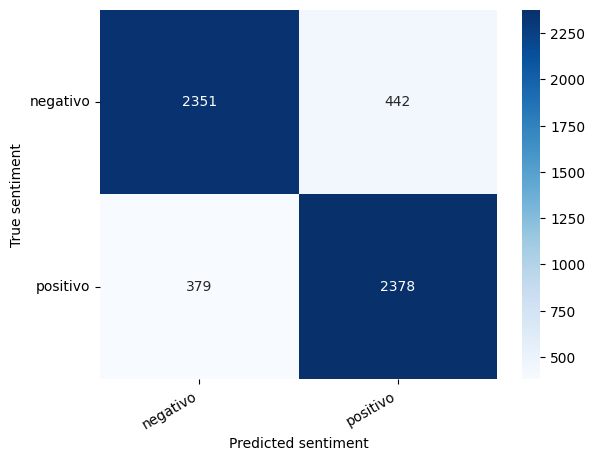

In [45]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment');
  
cm = confusion_matrix(test_predictions,test_real_values)
df_cm = pd.DataFrame(cm, index=classes_names, columns=classes_names)
show_confusion_matrix(df_cm)



## Sentiment prediction

In [75]:
import re
import spacy
def predict_tratamento_texto(text: str, lemma:bool):
    nlp = spacy.load("en_core_web_sm", exclude=["parser", "ner"])
    text = text.lower()
    text = re.sub(r"\s+", " ", text).strip()
    # remover html
    # text = re.sub(re.compile("<.*?>"), "", text)
    doc = nlp(text)
    if lemma == True:
        text = " ".join(
            [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
        )  # retorna o lemma
    else:
        text = " ".join(
            [token.text for token in doc if not token.is_stop and not token.is_punct]
        )  # return text
    return text


In [76]:

def predict_sentiment(
    text: str,
    model: MultiClassClassifier,
    tokenizer: BertTokenizer,
    device: str,
    max_length: int,
    lemma=False,
):
    model.eval()
    text = predict_tratamento_texto(text, lemma)
    encoding = tokenizer(
        text,
        return_tensors="pt",
        max_length=max_length,
        padding="max_length",
        truncation=True,
    )
    input_ids = encoding["input_ids"].to(device)
    attention_mask = encoding["attention_mask"].to(device)

    with torch.no_grad():
        output = model(input_ids=input_ids, attention_mask=attention_mask)
        prob = F.softmax(output,dim=1)
    prob_neg = prob[0, 0].item()
    prob_pos = prob[0, 1].item()
    print(f"prob negativa: {prob_neg:.5f}")
    print(f"prob positiva: {prob_pos:.5f}")

    classes = ["negativo", "positivo"]
    predicted_class_index = torch.argmax(prob, dim=1).item()
    predicted_class = classes[predicted_class_index]
    return predicted_class

In [77]:
# Challengers 1/10
text= """The audience was in hysterics by the end. The choices made in every aspect of this movie were shockingly bad. The abysmal and strange music, the constant shift in time, the laughable script, the nauseating camera work, and just truly one of the worst directed films I've ever seen. I would have left halfway through if I didn't have to pay for my food. But I'm glad I stayed because it got so much more hysterically bad than I even thought possible. I feel like I'm insane because the audience was screaming with laughter. I got the sense that the director thinks he's a genius, but this movie is 1% short of a feature length SNL parody."""

In [78]:
sentiment = predict_sentiment(text, model, tokenizer, device, max_length)
print(predict_tratamento_texto(text,lemma= False))
print(f"Predicted sentiment: {sentiment}")

prob negativa: 0.99140
prob positiva: 0.00860
audience hysterics end choices aspect movie shockingly bad abysmal strange music constant shift time laughable script nauseating camera work truly worst directed films seen left halfway pay food glad stayed got hysterically bad thought possible feel like insane audience screaming laughter got sense director thinks genius movie 1 short feature length snl parody
Predicted sentiment: negativo


In [79]:
# The Fall Guy 2/10
text = """Almost ok! But not good or great. Could had been.  It was evident that the makers of this movie never saw more than couple of episodes of Fall guy the TV series it's based on. There were more reference to Miami vice tv series than the actual tv series this movie is supposedly based on. First half an hour or so of the movie was pure cringe. The dialogues were written by couple of teenagers who were probably paid in TikTok views. The rom com scenes were cringy and unwatchable.  Action sequences and stunts were excellent but kept getting interrupted by really really awful cringy love story. One scene ( not a spoiler) where the action sequence keeps breaking away to a cringey Karakoram no , made us almost walk out of the movie.  Some of the acting is sooo bad.  If you make a movie based on the TV series Atleast watch every episode of it. We did. The tv series that made every kid want to get a pickup truck and be a stunt man. The tv series which made kids attempt dangerous stunts on their bikes.  And the actual fall guy Lee majors. Makes an appearance post credit? Really. Why even bother.  Was ok but a missed opportunity to make it great."""

In [80]:
sentiment = predict_sentiment(text, model, tokenizer, device, max_length)
print(predict_tratamento_texto(text,lemma= False))
print(f"Predicted sentiment: {sentiment}")

prob negativa: 0.99145
prob positiva: 0.00855
ok good great evident makers movie saw couple episodes fall guy tv series based reference miami vice tv series actual tv series movie supposedly based half hour movie pure cringe dialogues written couple teenagers probably paid tiktok views rom com scenes cringy unwatchable action sequences stunts excellent kept getting interrupted awful cringy love story scene spoiler action sequence keeps breaking away cringey karakoram walk movie acting sooo bad movie based tv series atleast watch episode tv series kid want pickup truck stunt man tv series kids attempt dangerous stunts bikes actual fall guy lee majors makes appearance post credit bother ok missed opportunity great
Predicted sentiment: negativo


In [81]:
# THe Idea of You 3/10
text= """Oh dear. Absolutely no chemistry between the two main characters. The lead female Solene, apart from the absurd name is totally unrelatable or endearing. She acts like his teacher, or mother "I'll make you a sandwich?!" When she talks about herself he's uncomfortably interested, uncomfortable because it's not believable. The art they show in the gallery and warehouse are pretentious and boring, a lot like Solene. I'm surprised at the positive reviews.  It's mildly entertaining - a background movie for when you're building Lego for example. But I couldn't take the pairing seriously. Maybe I'm feeling the uncomfortable atmosphere that potentially could have been on set that I'm picking up on? I dunno. It could've been so much better with a different female lead."""

In [82]:
sentiment = predict_sentiment(text, model, tokenizer, device, max_length)
print(predict_tratamento_texto(text,lemma= False))
print(f"Predicted sentiment: {sentiment}")

prob negativa: 0.98926
prob positiva: 0.01074
oh dear absolutely chemistry main characters lead female solene apart absurd totally unrelatable endearing acts like teacher mother sandwich talks uncomfortably interested uncomfortable believable art gallery warehouse pretentious boring lot like solene surprised positive reviews mildly entertaining background movie building lego example pairing seriously maybe feeling uncomfortable atmosphere potentially set picking dunno better different female lead
Predicted sentiment: negativo


In [83]:
# nota 4
text= """I'm a big fan of Garland's earlier films (Ex Machina, Annihilation) and wanted to like this, but sadly this one was a miss. There's not really a story - no reason why the war is happening or what is at stake. The characters are extremely unrelatable and are more there just to represent concepts (the media, racism, etc) rather than have any identity of their own. The war just happens to be there in the background while the characters are taking a roadtrip through rural America, which doesn't actually show any war going on, just random series of fights which could just be regular gun violence from today. You would hardly know there's a war going on except the characters telling you there is.  It's not until the last 10 minutes that you see any military operations and it lacks scale for only seemingly having about 100 troops fighting, given what's supposedly at stake. The movie should've started here and gone backwards into why the war is happening, which would've made a more interesting film in my opinion.

"""

In [84]:
sentiment = predict_sentiment(text, model, tokenizer, device, max_length)
print(predict_tratamento_texto(text,lemma= False))
print(f"Predicted sentiment: {sentiment}")

prob negativa: 0.99142
prob positiva: 0.00858
big fan garland earlier films ex machina annihilation wanted like sadly miss story reason war happening stake characters extremely unrelatable represent concepts media racism etc identity war happens background characters taking roadtrip rural america actually war going random series fights regular gun violence today hardly know war going characters telling 10 minutes military operations lacks scale seemingly having 100 troops fighting given supposedly stake movie started gone backwards war happening interesting film opinion
Predicted sentiment: negativo


In [85]:
# Anyone But You 5/10
 
text = """They really did make a whole movie just to show off Glen Powell's smoking hot body and honestly - I'm here for it! The storyline and the acting is... wait, who cares?? Glen Powell is shirtless about half the time. This is a movie about two people who fall in love only to find out that... Glen Powell's body is so hot! If you watch the trailer you already know exactly what happ... Glen Powell!! The predictability factor is super strong with this one. The cheese is sprinkled all over the movie, in every scene, there is little room left for any other ingredients because... cheese. And Glen Powell.  Glen Powell"""

In [86]:
sentiment = predict_sentiment(text, model, tokenizer, device, max_length)
print(predict_tratamento_texto(text,lemma= False))
print(f"Predicted sentiment: {sentiment}")

prob negativa: 0.99044
prob positiva: 0.00956
movie glen powell smoking hot body honestly storyline acting wait cares glen powell shirtless half time movie people fall love find glen powell body hot watch trailer know exactly happ glen powell predictability factor super strong cheese sprinkled movie scene little room left ingredients cheese glen powell glen powell
Predicted sentiment: negativo


In [87]:
# Capita marvel 2019 5/10 
text = """Plot  Carol Danvers     becomes one of the universe's most powerful heroes when Earth is caught in the middle of a galactic war between two alien races.  Cast  Brie Larson, Samuel L. Jackson (Because duh), Jude "Just consistently dreadful" Law, Annette Bening, Djimon Hounsou, Clark Gregg and blink and you'll miss him Lee Pace who returns as Ronan but looks so different I didn't even think it was him.  Verdict  I watched this back when it was initially released, I watched it a second time a few days ago as the missus is wanting us to binge watch the entire MCU as she's very behind. My opinion has changed on the 2nd viewing and not in a good way, my rating has shifted from a 6/10 to 5/10.  You see straight out of the gate the first thing you notice about Carol Danvers is she's not really a character you can get behind. She's not funny, she's not entertaining, she comes across as a surly teenage girl who is just upset at the slightest thing and just doesn't want to be there. This is not a character you can build a movie around, like trying to make a teenage Groot movie! It wouldn't work, but he's okay as a side character.  Supporting cast are also hit and miss, Jackson and Gregg are great, but Lynch and Law just stink up every scene they're in.  I'm a Marvel fan but I recognize where it's weak, this is a distinctly average film that serves as a standalone origin story and doesn't contribute much to the universe as a whole.  Rants  I remember when the movie came out all the controversy with Brie Larson, I just had to Google what the controversy even was as I don't remember due to not focusing on such things. Now I can't really get a definitive answer. From what I see it's a combination of people not liking her attitude and her comments on feminism. So I Googled further to see what she said, she came across arrogant in them and a smidge out of touch but none of it explained the overwhelming hate I've seen aimed at her. Then I remembered that people talk about all the different types of bigotry but misogyny rarely comes up, I remembered that it's visibly increased over the past decade and appreciated why she's been targeted. News flash, the outspoken loud brash man hating femnists you likely thing of when you hear that word make up a very small percentage. Feminism is good, if you disagree I hope you simply don't know the meaning of the word.  The Good  Jackson and Gregg Has a couple of decent moments Not a bad soundtrack Goose!  The Bad  Larson isn't great Law and Lynch are terrible Lead just comes across unlikable.  Overall just a weak entry to the MC """

In [88]:
# nota 5 = neutra
sentiment = predict_sentiment(text, model, tokenizer, device, max_length)
print(predict_tratamento_texto(text,lemma= False))
print(f"Predicted sentiment: {sentiment}")

prob negativa: 0.97506
prob positiva: 0.02494
plot carol danvers universe powerful heroes earth caught middle galactic war alien races cast brie larson samuel l. jackson duh jude consistently dreadful law annette bening djimon hounsou clark gregg blink miss lee pace returns ronan looks different think verdict watched initially released watched second time days ago missus wanting binge watch entire mcu opinion changed 2nd viewing good way rating shifted 6/10 5/10 straight gate thing notice carol danvers character funny entertaining comes surly teenage girl upset slightest thing want character build movie like trying teenage groot movie work okay character supporting cast hit miss jackson gregg great lynch law stink scene marvel fan recognize weak distinctly average film serves standalone origin story contribute universe rants remember movie came controversy brie larson google controversy remember focusing things definitive answer combination people liking attitude comments feminism goog

In [89]:
# CApita marvel 2019 6/10
text="""Mediocre Marvel is still pretty good. My first review in a long time! Dont know why I decided to write about this movie. I agree with most mediocre reviews I read here. The pacing was pretty good. Most of the action was good! The story was ok and had some good twists. I thought about giving this movie a 6 but after letting it sink in I decided to give it 8 out of 10 It entertained me and my company from beginning to end. There were some eye rolling moments but they are easily forgiven."""

In [90]:
sentiment = predict_sentiment(text, model, tokenizer, device, max_length)
print(predict_tratamento_texto(text,lemma= False))
print(f"Predicted sentiment: {sentiment}")

prob negativa: 0.97745
prob positiva: 0.02255
mediocre marvel pretty good review long time nt know decided write movie agree mediocre reviews read pacing pretty good action good story ok good twists thought giving movie 6 letting sink decided 8 10 entertained company beginning end eye rolling moments easily forgiven
Predicted sentiment: negativo


In [91]:
# Duna parte 2 6/10 
text ="""Dune Part 2 is an epic movie; slickly made, and visually stunning.  But I had to explain quite a bit to the friends around me who had not read the book, especially the water of life scene and the final battle.  The movie had almost a 3 hour run time, but it felt overlong because Villenue focuses too much on spectacle on very little on substance.  It is a beautiful movie, but it feels like it has no soul. The emotional connection between Paul and Chani, so vital to the story, is completely lacking and unbelievable. The two main characters are good looking enough but has absolutely zero chemistry on screen.  I am certain Zendaya is a fine actress in some things, but she has basically 2 facial expressions here, and the one she uses the most is a scowl directed at Paul. I found her to be the worst part of this movie.  The final fight scene is short, choppy, and a mess. It felt anticlimactic and unfulfilling The Harkonens are basically reduced to bumbling villainy almost cartoonish. The ending was super abrupt, and was so different from the book that it left me wondering what the filmmakers would do if they want to do a sequel.  I want to reiterate that this isn't a bad movie. Villenue is great at creating a world that looks living and breathing, but he can't give life to individual characters.  It is like he can't see the trees for the forest."""

In [92]:
sentiment = predict_sentiment(text, model, tokenizer, device, max_length)
print(predict_tratamento_texto(text,lemma= False))
print(f"Predicted sentiment: {sentiment}")

prob negativa: 0.97218
prob positiva: 0.02782
dune 2 epic movie slickly visually stunning explain bit friends read book especially water life scene final battle movie 3 hour run time felt overlong villenue focuses spectacle little substance beautiful movie feels like soul emotional connection paul chani vital story completely lacking unbelievable main characters good looking absolutely zero chemistry screen certain zendaya fine actress things basically 2 facial expressions uses scowl directed paul found worst movie final fight scene short choppy mess felt anticlimactic unfulfilling harkonens basically reduced bumbling villainy cartoonish ending super abrupt different book left wondering filmmakers want sequel want reiterate bad movie villenue great creating world looks living breathing life individual characters like trees forest
Predicted sentiment: negativo


In [93]:
# duna parte 2 7/10 
text ="""I mean, yeah, it's very entertaining and, of course, very visually stunning. The set pieces, the cinematography, the use of visual effects and lights, the sound design and music, all, absolutely amazing and almost literally stunning!  But then? I'm not really seeing much after that. As I have not read the books, this movie was a total mystery to me. There's barely any dialog--at least not any that would explain anything what's going on at all. The world and the technology etc just doesn't make much sense to me.  None of the characters are particularly interesting, to be honest. They don't really have that much personality to them, and even if they did, they didn't really make me care about them all that much.  I don't know, I'm a bit conflicted, it wasn't a bad movie and, as I said, it was entertaining and visually mesmerizing, but it lacked the depth that I was expecting of a world this size and this rich with lore and history_epoch. Maybe the movie makers assumed everyone has read the books? As someone to who the world is not familiar at all, it just seems rather confusing and strange. I feel like they just focused on making it as visually awesome as they can (in which they arguably succeeded), but left the story on the pages of the books."""

In [94]:
sentiment = predict_sentiment(text, model, tokenizer, device, max_length)
print(predict_tratamento_texto(text,lemma= False))
print(f"Predicted sentiment: {sentiment}")

prob negativa: 0.97257
prob positiva: 0.02743
mean yeah entertaining course visually stunning set pieces cinematography use visual effects lights sound design music absolutely amazing literally stunning seeing read books movie total mystery barely dialog explain going world technology etc sense characters particularly interesting honest personality care know bit conflicted bad movie said entertaining visually mesmerizing lacked depth expecting world size rich lore history_epoch maybe movie makers assumed read books world familiar confusing strange feel like focused making visually awesome arguably succeeded left story pages books
Predicted sentiment: negativo


In [95]:
# Love Lies Bleeding (2024) 8/10 
text="""Love Lies Bleeding is a bigger, bolder, and more violent follow-up feature for Rose Glass. It literally puts the premise of Thelma & Louise on steroids with a very muscular approach that goes for broke in its ending which, love it or hate it, is to be commended for its audacity. Body horror, romance, and dark comedy are all blended into one distinctive vision.  Kristen Stewart is amazing, awkward and off hand with one of the best dramatic pauses of recent memory. Katy O'Brian has been massively under served by her roles in the big franchises which makes this much more layered performance all the more satisfying. Together, their chemistry is instant and they communicate how badly they want each other so well.  Ed Harris has played a lot of villains so its a real testament to his performance and the writing of the character that this one still stands out. His long haired, bug eating gangster makes for a consistently creepy highlight. Also, Dave Franco does a great job as a spineless abusive husband who's fate is obvious and all the more satisfying because of how he plays it.  Saint Maud definitely wasn't lacking in vision but Rose Glass has really upped her craft here. From its reality manipulating opening scene to the extreme close ups of muscles in action, it's clear that the film will move between extremes as it deftly balances the violence and body horror against an affecting romance that refuses to go for the most obvious outcomes.  The sound design and editing here is so visceral. Gunshots feel scary as they often come out of nowhere and the way scenes can abruptly switch between very different soundscapes keeps you on edge. Clint Mansell's score really matches the song choices for a seamless soundtrack whilst being completely distinct."""

In [96]:
sentiment = predict_sentiment(text, model, tokenizer, device, max_length)
print(predict_tratamento_texto(text,lemma= False))
print(f"Predicted sentiment: {sentiment}")

prob negativa: 0.02146
prob positiva: 0.97854
love lies bleeding bigger bolder violent follow feature rose glass literally puts premise thelma louise steroids muscular approach goes broke ending love hate commended audacity body horror romance dark comedy blended distinctive vision kristen stewart amazing awkward hand best dramatic pauses recent memory katy o'brian massively served roles big franchises makes layered performance satisfying chemistry instant communicate badly want ed harris played lot villains real testament performance writing character stands long haired bug eating gangster makes consistently creepy highlight dave franco great job spineless abusive husband fate obvious satisfying plays saint maud definitely lacking vision rose glass upped craft reality manipulating opening scene extreme close ups muscles action clear film extremes deftly balances violence body horror affecting romance refuses obvious outcomes sound design editing visceral gunshots feel scary come way s

In [97]:
# The Godfather Part II (1974) 9/10
text ="""Although the casual way it has been titled leaves it with plenty to answer for, 'Godfather II' rightly remains the only sequel ever to win an Oscar for Best Picture of the year.  With Brando out of the picture the focus has shifted to Michael and much more money was obviously available to spend on the movie itself (with plush production design and cool fifties cars gliding across the screen a recurrent motif).  Robert De Niro as the young Don Corleone brings a lean and hungry look to the part by then completely beyond Brando (by comparison Al Pacino looks much older).  The film is far more ambitious, both technically and thematically, addressing America's changing role in the world rather than just the activities of one family."""

In [98]:
sentiment = predict_sentiment(text, model, tokenizer, device, max_length)
print(predict_tratamento_texto(text,lemma= False))
print(f"Predicted sentiment: {sentiment}")

prob negativa: 0.03871
prob positiva: 0.96129
casual way titled leaves plenty answer godfather ii rightly remains sequel win oscar best picture year brando picture focus shifted michael money obviously available spend movie plush production design cool fifties cars gliding screen recurrent motif robert de niro young don corleone brings lean hungry look completely brando comparison al pacino looks older film far ambitious technically thematically addressing america changing role world activities family
Predicted sentiment: positivo


In [99]:
# The Godfather Part II (1974) 10/10

text = """One of the all time greats. Or probably the alone greatest thing ever made in the history_epoch of cinematography. This movie is both "prequel" and "sequel" of the first godfather movie. I have never watched anything like this in my entire life. This movie has explained the life of underworld people in a great way. It also shows how vengeance eradicates happiness from your life. People don't even care about their family in greed of power. It's a masterpiece that can never be written off even after centuries. Even if you are not into these kind of movies, I will suggest to watch it for atleast once in your life or you'll be deprived of one of the greatest things to watch that have been ever made."""

In [100]:
sentiment = predict_sentiment(text, model, tokenizer, device, max_length)
print(predict_tratamento_texto(text,lemma= False))
print(f"Predicted sentiment: {sentiment}")

prob negativa: 0.33928
prob positiva: 0.66072
time greats probably greatest thing history_epoch cinematography movie prequel sequel godfather movie watched like entire life movie explained life underworld people great way shows vengeance eradicates happiness life people care family greed power masterpiece written centuries kind movies suggest watch atleast life deprived greatest things watch
Predicted sentiment: positivo


### Simples test sentiment prections

In [101]:
# Test sentiment prediction
test_text = "The movie was so bad and I would not recommend it to anyone."
sentiment = predict_sentiment(test_text, model, tokenizer, device, max_length)
print("Texto: ", test_text)
print(f"Predicted sentiment: {sentiment}")

prob negativa: 0.97269
prob positiva: 0.02731
Texto:  The movie was so bad and I would not recommend it to anyone.
Predicted sentiment: negativo


In [102]:
# Test sentiment prediction
test_text = "Best movie of the year. "
sentiment = predict_sentiment(test_text, model, tokenizer, device, max_length)
print("Worst movie of the year.")
print(f"Predicted sentiment: {sentiment}")

prob negativa: 0.02164
prob positiva: 0.97836
Worst movie of the year.
Predicted sentiment: positivo


In [103]:
# Test sentiment prediction
test_text = "This movie is more or less,and I would not recommend it to anyone, but i busy."
sentiment = predict_sentiment(test_text, model, tokenizer, device, max_length)
print(test_text)
print(f"Predicted sentiment: {sentiment}")

prob negativa: 0.55330
prob positiva: 0.44670
This movie is more or less,and I would not recommend it to anyone, but i busy.
Predicted sentiment: negativo
